In [1]:
import datetime as dt
import itertools as it
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.ticker as mtick
from matplotlib.gridspec import GridSpec
from matplotlib import rc

rc('axes', fc='w')
rc('figure', fc='w')
rc('savefig', fc='w')
rc('axes', axisbelow=True)

## Plotting style

In [2]:
rc('font', **{'family':'sans-serif'})
rc('text', usetex=False)

lw = 2.25
fs = 10.0
al = 0.95

foc_m_cols = {'solo':'#777777', 0:'#0B9A85', 1:"#76C1CA"}
foc_d_cols = {'solo':'#222222', 0:'#105C51', 1:"#208896"}

label_cols = {'main':'#111111', 'accent':'#C69F52', 'tick':'#333333'}

color_cmap = plt.cm.RdYlBu

pe_dat_l = [path_effects.Stroke(linewidth=lw*1.5,foreground='#FFFFFF',alpha=al),
            path_effects.Normal()]
pe_dat_d = [path_effects.Stroke(linewidth=lw*1.5,foreground='#111111',alpha=al),
            path_effects.Normal()]
pe_lab_l = [path_effects.Stroke(linewidth=1.0, foreground='#FFFFFF'),
            path_effects.Normal()]
pe_lab_d = [path_effects.Stroke(linewidth=1.0, foreground='#111111'),
            path_effects.Normal()]

colors = [foc_m_cols[1],foc_d_cols[0],'#5E8BE3']
pe_dat_t = [path_effects.Stroke(linewidth=lw*1.5,foreground='#FFFFFF',alpha=al),
            path_effects.Normal()]

# Load data

In [3]:
df = pd.read_csv('../data/populations_states.csv')
state_list = df['state'].unique()
print(df.shape)
df.head()

(9585, 13)


date data_or_inferred  incarcerated_total  incarcerated_white  \
0  2000-01-01         raw data             25213.0                8753   
1  2000-02-01         raw data             25213.0                8753   
2  2000-03-01         raw data             25161.0                8723   
3  2000-04-01         raw data             25200.0                8738   
4  2000-05-01         raw data             25226.0                8788   

   incarcerated_black  incarcerated_hispanic  incarcerated_amerind  \
0             16382.0                    NaN                   NaN   
1             16382.0                    NaN                   NaN   
2             16361.0                    NaN                   NaN   
3             16380.0                    NaN                   NaN   
4             16358.0                    NaN                   NaN   

   incarcerated_asian  incarcerated_other  incarcerated_unknown  \
0                 NaN                78.0                   NaN   
1                 NaN                78.0                   NaN   
2                 NaN                77.0                   NaN   
3                 NaN                82.0                   NaN   
4                 NaN                80.0                   NaN   

   incarcerated_nonwhite    state                                     url  
0                16460.0  Alabama  http://www.doc.state.al.us/StatReports  
1                16460.0  Alabama  http://www.doc.state.al.us/StatReports  
2                16438.0  Alabama  http://www.doc.state.al.us/StatReports  
3                16462.0  Alabama  http://www.doc.state.al.us/StatReports  
4                16438.0  Alabama  http://www.doc.state.al.us/StatReports

In [4]:
# For initial figure, exclude Federal data:
dfx = df.loc[(df['state']!='Federal')&\
             (df['date']>='2013-01-01')&\
             (df['date']<='2022-01-01')].copy()
dft = dfx.groupby(['date']).agg({'incarcerated_total':'sum'}).reset_index()
dft['date'] = pd.to_datetime(dft['date'])
dft = dft.set_index('date')

# Exclude Michigan as well -- only report "white" and "nonwhite" for race categories
dfx_nmich = dfx.loc[(dfx['state']!='Michigan')].copy()
dfg_nmich = dfx_nmich.groupby(['date']).agg({'incarcerated_total':'sum',
                                             'incarcerated_black':'sum',
                                             'incarcerated_white':'sum'}).reset_index()
dfg_nmich['date'] = pd.to_datetime(dfg_nmich['date'])
dfg_nmich = dfg_nmich.set_index('date')

# Figure 1

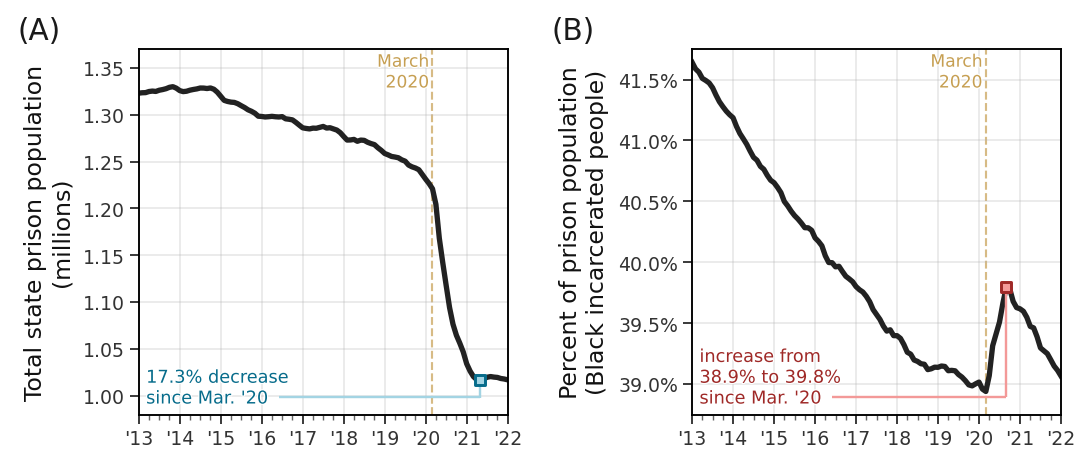

In [5]:
w = 7; h = 2.85
fig, ax = plt.subplots(1,2,figsize=(w,h),dpi=170,sharex=True)
plt.subplots_adjust(wspace=0.5)

dft['incarcerated_total'].plot(ax=ax[0], lw=lw, color=foc_d_cols['solo'])

yts = np.array([1000000., 1050000., 1100000., 1150000.,
                1200000., 1250000., 1300000., 1350000.])
ax[0].set_yticks(yts)
ax[0].set_yticklabels(['%.2f'%i for i in yts/1000000])
ax[0].set_ylim(980000, 1370000)
ax[0].set_ylabel('Total state prison population\n(millions)',
                 fontsize=fs, color=label_cols['main'])


dec_tot = dft['incarcerated_total']['2019-12-01']
mar_tot = dft['incarcerated_total']['2020-03-01']
cur_tot = dft['incarcerated_total'].min()

dif_tot_pct = np.round((mar_tot-cur_tot)/np.mean([dec_tot,mar_tot])*100,1)
dif_tot_pct = np.round((cur_tot)/np.mean([dec_tot,mar_tot])*100,1)
dif_text = "%.1f%% decrease\nsince Mar. '20"%(100-dif_tot_pct)
tcol = '#076C8B'
tc2 = '#A3D4E3'

min_pop = dft[dft['incarcerated_total']==dft['incarcerated_total'].min()].index.astype(str)[0]

ax[0].scatter([pd.to_datetime([min_pop]).min()], cur_tot,
              ec=tcol, fc=tc2, marker='s', zorder=10, s=15, lw=1.25)
ax[0].vlines(pd.to_datetime([min_pop]).min(),
             dft['incarcerated_total'].min(),
             dft['incarcerated_total'].min()*0.982,
             color=tc2, ls='-', lw=lw*0.45, zorder=3)
ax[0].hlines(dft['incarcerated_total'].min()*0.9825,
             pd.to_datetime([min_pop]).min(),
             pd.to_datetime(['2016-06-01']).min(),
             color=tc2, ls='-', lw=lw*0.45, zorder=3)
ax[0].text(0.02, 0.02, dif_text, ha='left', va='bottom', fontsize=fs*0.75,
           color=tcol, path_effects=pe_lab_l, transform=ax[0].transAxes)


dfg_nmich['pct_black'] = dfg_nmich['incarcerated_black']/dfg_nmich['incarcerated_total']
dfg_nmich['pct_black'].plot(ax=ax[1], lw=lw, color=foc_d_cols['solo'])
ylim_i = ax[1].get_ylim()
tcol = '#9F2927'
tc2 = '#F39998'
dma = dfg_nmich['pct_black']['2020-01-01':].max()
max_per = dfg_nmich['pct_black']['2020-01-01':][dfg_nmich['pct_black']['2020-01-01':]==dma].index.astype(str)[0]

dif_text2 = "increase from\n%.1f%% to %.1f%%\nsince Mar. '20"%(100*dfg_nmich['pct_black'].min(),100*dma)
ax[1].scatter([pd.to_datetime([max_per]).min()], dma,
              ec=tcol, fc=tc2, marker='s', zorder=10, s=15, lw=1.25)
ax[1].vlines(pd.to_datetime([max_per]).min(),
             dma, dma*0.9772,
             color=tc2, ls='-', lw=lw*0.45, zorder=3)
ax[1].hlines(dma*0.9772,
             pd.to_datetime([max_per]).min(),
             pd.to_datetime(['2016-06-01']).min(),
             color=tc2, ls='-', lw=lw*0.45, zorder=3)
ax[1].text(0.02, 0.02, dif_text2, ha='left', va='bottom', fontsize=fs*0.75,
           color=tcol, path_effects=pe_lab_l, transform=ax[1].transAxes)

ax[1].set_ylabel('Percent of prison population\n(Black incarcerated people)',
                 fontsize=fs, color=label_cols['main'])
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=1))

ax[1].set_ylim(0.3875,0.4175)
# ax[1].set_ylim(ylim_i[0], ylim_i[1])

letts = ['(A)','(B)']
for ai, a in enumerate(fig.axes):
    a.set_xlabel('')
    a.text(-0.33-ai*0.05, 1.01, letts[ai], fontsize=fs*1.25, transform=a.transAxes,
           ha='left', va='bottom', color='.1')
    a.tick_params(which='both', length=4, pad=2, labelsize=fs*0.8,
                  labelcolor=label_cols['tick'], color=label_cols['tick'])
    a.tick_params(which='minor', length=2, color='.4')
    a.set_xticks(pd.to_datetime(list(dft.index[::12].astype(str))), minor=False)
    a.set_xticklabels(["'"+i[2:4] for i in list(dft.index[::12].astype(str))])
    ylims = a.get_ylim()
    ydiff = ylims[1]-ylims[0]
    xlims = a.get_xlim()
    xdiff = xlims[1]-xlims[0]
    a.vlines(pd.to_datetime(['2020-03-01']).min(), ylims[0], ylims[1], 
             color=label_cols['accent'], zorder=0, ls='--', lw=lw*0.4, alpha=0.7)
    a.text(pd.to_datetime(['2020-02-01']).min(), ylims[1]-ydiff*0.01,"March\n2020",
           ha='right', va='top', fontsize=fs*0.725, #rotation=90,
           color=label_cols['accent'], path_effects=pe_lab_l)
    a.set_ylim(ylims[0], ylims[1])
    a.grid(color='.7', alpha=al*0.3, lw=lw/3)

plt.savefig('../figs/pngs/nationwide_stateprisonpop_pctblack_longterm_sep22.png',dpi=600,bbox_inches='tight')
plt.savefig('../figs/pdfs/nationwide_stateprisonpop_pctblack_longterm_sep22.pdf',bbox_inches='tight')
plt.show()

______________

In [6]:
states_focus = ['Georgia', 'Pennsylvania', 'Kentucky', 'California', 'Connecticut',
                'Arizona', 'Texas', 'Florida', 'Washington', 'Delaware', 'Nevada', 'New York']

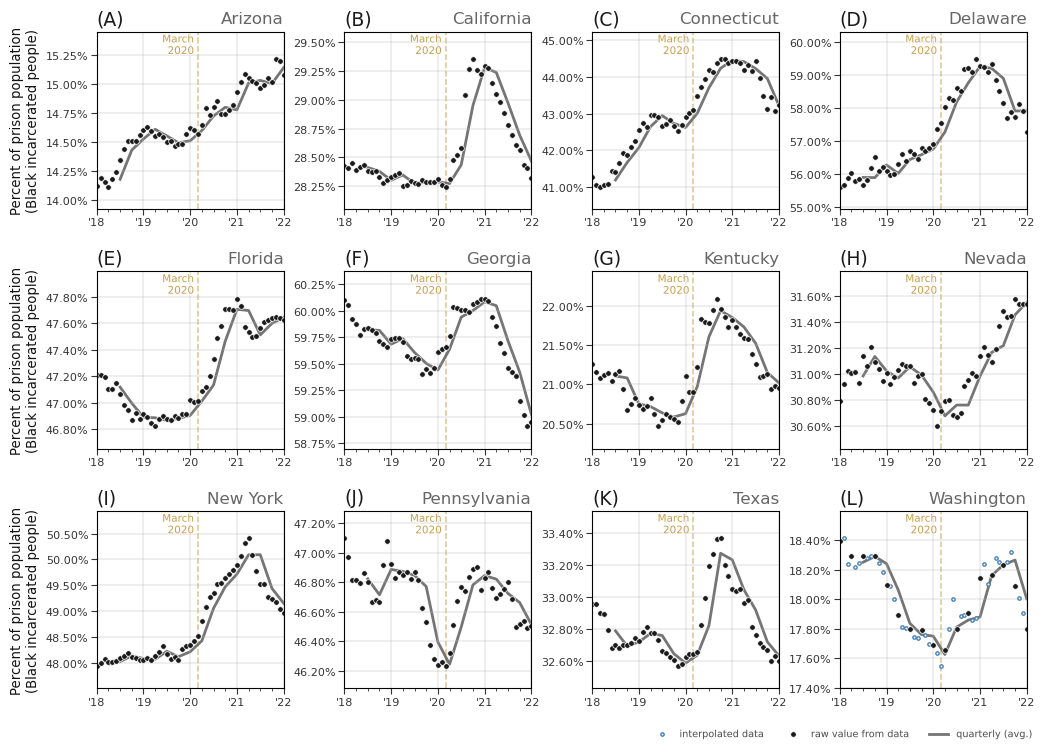

In [7]:
stdate = '2017-12-01'
endate = '2022-02-01'

rc('axes', axisbelow=True)
w = 3.0
h = 2.9
ncols = 4
nrows = 3
tups = list(it.product(range(nrows), range(ncols)))

fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100)
plt.subplots_adjust(wspace=0.325,hspace=0.35)

rcol = 'incarcerated_black'
tcol = 'incarcerated_total'

ms = 8
letts = ['(A)','(B)', '(C)', '(D)', '(E)', '(F)', '(G)', '(H)', '(I)', '(J)', '(K)', '(L)']
for i, st in enumerate(sorted(states_focus)):
    a = ax[tups[i]]
    dfg_st = df.loc[df['state']==st].copy()
    df_i = df.loc[(df['state']==st)&\
                  (df['date']>stdate)&\
                  (df['date']<endate)].copy()
    df_i['date'] = pd.to_datetime(df_i['date'])
    df_i = df_i.set_index('date')
    if st == 'Washington':
        df_i.loc['2020-03-01','incarcerated_black'] = (df_i['incarcerated_total']['2020-03-01']*0.1755).astype(int)
        df_i.loc['2020-05-01','incarcerated_black'] = (df_i['incarcerated_total']['2020-05-01']*0.178).astype(int)
        df_i.loc['2020-06-01','incarcerated_black'] = (df_i['incarcerated_total']['2020-06-01']*0.18).astype(int)

    cccd = '#205078'
    cccl = '#5B98C5'
    cold = 'incarcerated_total'
    titleab = st

    cccd = '.1'
    cccl = '.4'
    all_vals = df_i[rcol]/df_i[tcol]
    df_i_raw = df_i.copy()
    df_i_raw.loc[df_i_raw['data_or_inferred']!='raw data',rcol] = np.nan
    df_i_nonraw = df_i.copy()
    df_i_nonraw.loc[df_i_nonraw['data_or_inferred']=='raw data',rcol] = np.nan

    all_vals.plot(ax=a, lw=0, color='w', label='_nolegend_')

    if df_i['data_or_inferred'].nunique()>1:
        (df_i_nonraw[rcol]/df_i_nonraw[tcol]).plot(ax=a,marker='.',lw=0,label='interpolated data',
                                                   markersize=ms*0.6,markeredgewidth=1.0,
                                                   markeredgecolor='steelblue', color='w')
    else:
        all_vals[:1].plot(ax=a,marker='.',lw=0,label='interpolated data',
                          markersize=ms*0.6,markeredgewidth=1.0,
                          markeredgecolor='steelblue', color='w')

    (df_i_raw[rcol]/df_i_raw[tcol]).plot(ax=a,marker='.',markersize=ms,
                                         markeredgewidth=0.5,markeredgecolor='w',
                                         lw=0, label='raw value from data', color='.1')

    df_iq = df_i.copy()
    qvals = (df_iq[rcol].resample('Q').mean()/df_iq[tcol].resample('Q').mean())
    qvals_i = qvals[1:-1].copy()
    if st not in ['Oklahoma','Maryland','Massachusetts','Indiana']:
        qvals_i.index = qvals_i.index + pd.DateOffset(months=1)
    qvals_i.plot(ax=a,lw=2,label='quarterly (avg.)', color='.4', alpha=0.9, zorder=0)

    a.set_xlabel('')
    if i in list(range(len(tups)))[::ncols]:
        a.set_ylabel('Percent of prison population\n(Black incarcerated people)',
                     fontsize=fs*0.95, color=label_cols['main'])
    ylims = a.get_ylim()
    ydiff = ylims[1]-ylims[0]
    ylims = [ylims[0]-ydiff*0.115, ylims[1]+ydiff*0.15]
    xlims = a.get_xlim()
    xdiff = xlims[1]-xlims[0]
    a.set_xticks(pd.to_datetime(list(df_i.index[::12].astype(str))), minor=False)
    a.set_xticklabels(["'"+i[2:4] for i in list(df_i.index[::12].astype(str))])

    a.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=2))
    a.tick_params(which='major', length=4, pad=2, labelsize=fs*0.8,
                  labelcolor=label_cols['tick'], color=label_cols['tick'])
    a.tick_params(which='minor', length=2, pad=2, labelsize=fs*0.8,
                  labelcolor=label_cols['tick'], color=label_cols['tick'])
    
    a.vlines(pd.to_datetime(['2020-03-15']).min(), ylims[0], ylims[1], 
             color=label_cols['accent'], zorder=0, ls='--', lw=lw*0.5, alpha=0.6)
    a.text(pd.to_datetime(['2020-02-01']).min(), ylims[1]-ydiff*0.02,"March\n2020",
           ha='right', va='top', fontsize=fs*0.75, #rotation=90,
           color=label_cols['accent'], path_effects=pe_lab_l)

    a.set_ylim(ylims[0], ylims[1])
    
    a.grid(color='.7', alpha=al*0.3, lw=lw/2)
    a.set_title(st, x=1.0, ha='right', color='.4')
    a.text(0, 1.02, letts[i], fontsize=fs*1.35, transform=a.transAxes,
           ha='left', va='bottom', color='.1')

l = a.legend(loc=2, fontsize=fs*0.7, framealpha=0, bbox_to_anchor=[-1.05,-0.18], ncol=3)
for t in l.get_texts():
    t.set_color('.3')
    t.set_path_effects(pe_lab_l)

plt.savefig('../figs/pngs/states_focus_pctblack12.png',dpi=600,bbox_inches='tight')
plt.savefig('../figs/pdfs/states_focus_pctblack12.pdf',bbox_inches='tight')

plt.show()

_____________

# Figure 3

In [8]:
from scipy.stats import linregress

df = pd.read_csv('../data/populations_states.csv')

dfx1 = df.loc[(df['date']>='2017-01-01')&\
              (df['date']<='2022-01-01')].groupby(['date']).agg({'incarcerated_total':'sum',
                                                                 'incarcerated_white':'sum',
                                                                 'state':'count'}).reset_index()
dfx1 = dfx1.loc[dfx1['state']==dfx1['state'].max()].copy().reset_index().iloc[:,1:]
dfx1['date'] = pd.to_datetime(dfx1['date'])
dfx1 = dfx1.set_index('date')

dfx_nmich1 = df.loc[(df['state']!='Michigan')].copy()
dfg_nmich1 = dfx_nmich1.loc[(dfx_nmich1['date']>='2017-01-01')&\
                            (dfx_nmich1['date']<='2022-01-01')].groupby(['date']).agg({'incarcerated_total':'sum',
                                                                                       'incarcerated_white':'sum',
                                                                                       'incarcerated_black':'sum',
                                                                                       'state':'count'}).reset_index()
dfg_nmich1['date'] = pd.to_datetime(dfg_nmich1['date'])
dfg_nmich1 = dfg_nmich1.set_index('date')

latino_states = df.loc[~df['incarcerated_hispanic'].isna()]['state'].unique()
df_lat1 = df.loc[(df['state'].isin(latino_states))&\
                 (df['date']>='2017-01-01')&\
                 (df['date']<'2022-01-01')].copy()

dfg_lat1 = df_lat1.groupby(['date']).agg({'incarcerated_total':'sum',
                                          'incarcerated_hispanic':'sum',
                                          'state':'count'}).reset_index()
dfg_lat1['date'] = pd.to_datetime(dfg_lat1['date'])
dfg_lat1 = dfg_lat1.set_index('date')

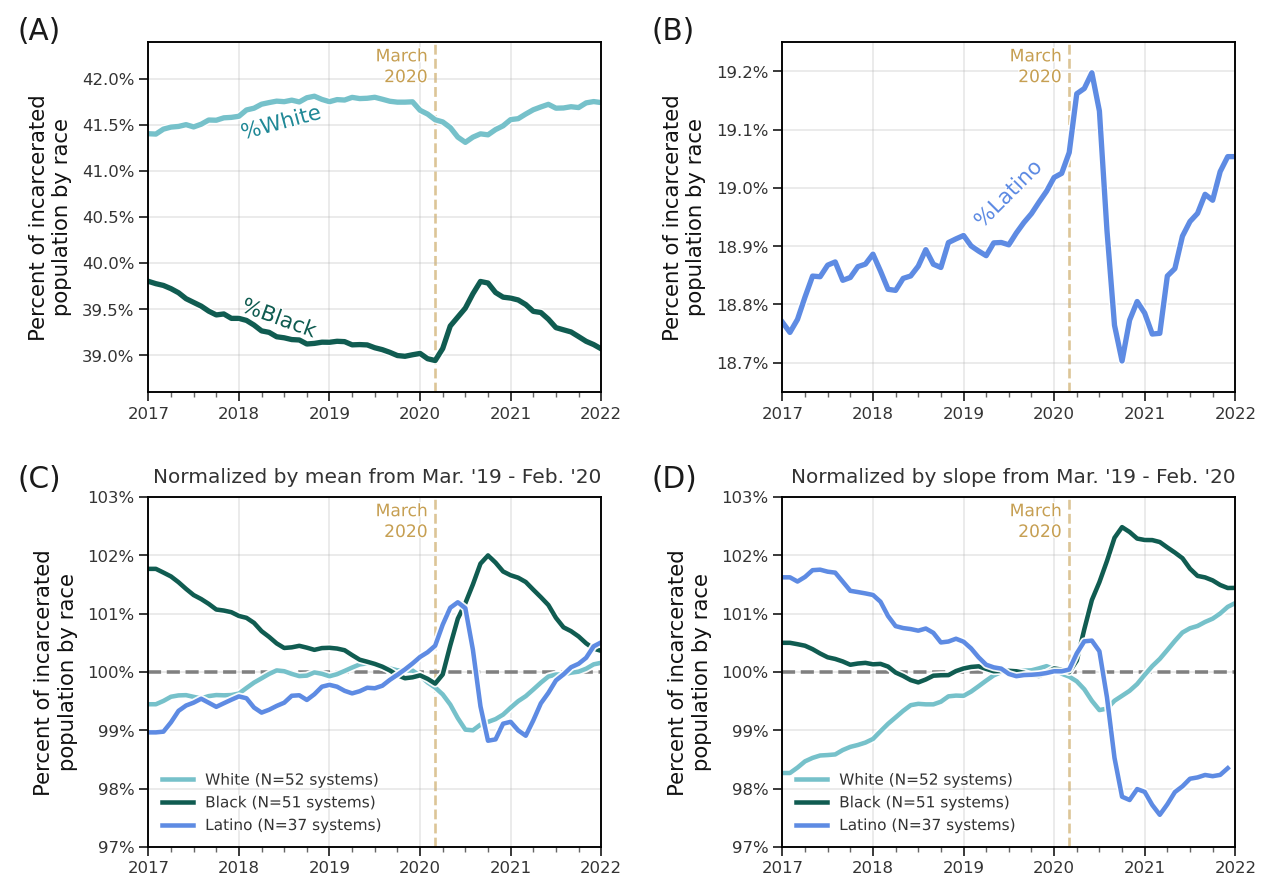

In [9]:
wid = 2
w = 8.25; h = 2.85*2.2
fig, ax = plt.subplots(2,2,figsize=(w,h),dpi=170)
plt.subplots_adjust(wspace=0.4,hspace=0.3)

bval = (dfg_nmich1['incarcerated_black']/dfg_nmich1['incarcerated_total'])
wvag = (dfx1['incarcerated_white']/dfx1['incarcerated_total'])
hisp = (dfg_lat1['incarcerated_hispanic']/dfg_lat1['incarcerated_total'])

labs = ['White (N=52 systems)','Black (N=51 systems)','Latino (N=37 systems)']
for ix,df_i in enumerate([wvag,bval,hisp]):
    allds_i = dict(zip(df_i.index.values,np.array(list(range(len(df_i.index))))))
    x_1 = np.array([allds_i[i] for i in df_i['2019-04-01':'2020-03-01'].index.values])
    sl_1, in_1, rv_1, pv_1, st_1 = linregress(x_1, df_i['2019-04-01':'2020-03-01'].values)
    
    y_1 = sl_1*np.array(list(allds_i.values())) + in_1
    ddd1 = pd.DataFrame({'date':df_i.index,"vals":y_1}).set_index('date')
    df_i["2022-01-01"] = df_i["2021-12-01"]
    v1 = (df_i/df_i['2019-04-01':'2020-03-01'].mean()).rolling(window=wid).mean()
    v1["2017-01-01"] = v1["2017-02-01"]
    v2 = (df_i/ddd1['vals']).rolling(window=wid).mean()
    v2["2017-01-01"] = v2["2017-02-01"]
    v1.plot(ax=ax[(1,0)],lw=lw*0.85, color=colors[ix], path_effects=pe_dat_t,label=labs[ix])
    v2.plot(ax=ax[(1,1)],lw=lw*0.85, color=colors[ix], path_effects=pe_dat_t,label=labs[ix])

    
ax[(1,0)].set_title("Normalized by mean from Mar. '19 - Feb. '20",
                 x=1.0,ha='right',fontsize=fs*0.85, color=label_cols['tick'])
ax[(1,1)].set_title("Normalized by slope from Mar. '19 - Feb. '20",
                 x=1.0,ha='right',fontsize=fs*0.85, color=label_cols['tick'])

dfg_nmich['pct_white'] = dfg_nmich['incarcerated_white']/dfg_nmich['incarcerated_total']
dfg_nmich['pct_black'] = dfg_nmich['incarcerated_black']/dfg_nmich['incarcerated_total']
dfg_nmich['pct_white']['2017-01-01':].plot(ax=ax[(0,0)], lw=lw, color=colors[0], path_effects=pe_dat_t)
dfg_nmich['pct_black']['2017-01-01':].plot(ax=ax[(0,0)], lw=lw, color=colors[1], path_effects=pe_dat_t)


dfg_lat1['pct_latino'] = dfg_lat1['incarcerated_hispanic']/dfg_lat1['incarcerated_total']
vv = dfg_lat1['pct_latino'].append(pd.Series([dfg_lat1['pct_latino'].values[-1]],
                                            index=[dfg_lat1['pct_latino'].index[-1]+pd.DateOffset(months=1)]))
vv['2017-01-01':].plot(ax=ax[(0,1)], lw=lw, color=colors[2], path_effects=pe_dat_t)


ax[(0,0)].text(pd.to_datetime(['2018-01-01']).min(), 0.3915, "%Black",
       ha='left', va='bottom', fontsize=fs*0.9, rotation=340,
       color=foc_d_cols[0], path_effects=pe_lab_l)
ax[(0,0)].text(pd.to_datetime(['2018-01-01']).min(), 0.413, "%White",
       ha='left', va='bottom', fontsize=fs*0.9, rotation=15,
       color=foc_d_cols[1], path_effects=pe_lab_l)
ax[(0,0)].set_ylim(0.386, 0.424)

ax[(0,1)].text(pd.to_datetime(['2019-02-01']).min(), 0.18925, "%Latino",
       ha='left', va='bottom', fontsize=fs*0.9, rotation=45,
       color=colors[2], path_effects=pe_lab_l)
ax[(0,1)].set_ylim(0.1865, 0.1925)


letts = ['(A)','(B)','(C)','(D)']
for ai, a in enumerate(fig.axes):
    if ai >= 2:
        a.set_xlabel('')
        a.text(-0.29, 1.01, letts[ai], fontsize=fs*1.25, transform=a.transAxes,
               ha='left', va='bottom', color='.1')
        a.set_ylabel('Percent of incarcerated\npopulation by race',
                     fontsize=fs*0.9, color=label_cols['main'])
        a.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))

        a.tick_params(which='both', length=4, pad=2, labelsize=fs*0.7,
                      labelcolor=label_cols['tick'], color=label_cols['tick'])
        a.tick_params(which='minor', length=2, color='.4')
        ylims = a.get_ylim()
        ylims = [0.97,1.03]
        ydiff = ylims[1]-ylims[0]
        xlims = a.get_xlim()
        xdiff = xlims[1]-xlims[0]
        a.hlines(1.0, df_i.index[0], df_i.index[-1], color='.5', ls='--')
        a.vlines(pd.to_datetime(['2020-03-15']).min(), ylims[0], ylims[1], 
                 color=label_cols['accent'], zorder=0, ls='--', lw=lw*0.5, alpha=0.6)
        a.set_ylim(ylims[0],ylims[1])
        a.text(pd.to_datetime(['2020-02-01']).min(), ylims[1]-ydiff*0.015,"March\n2020",
               ha='right', va='top', fontsize=fs*0.725, #rotation=90,
               color=label_cols['accent'], path_effects=pe_lab_l)
        a.grid(color='.7', alpha=al*0.3, lw=lw/3)
        l = a.legend(ncol=1,loc=3,fontsize=fs*0.65,framealpha=0)
        for text in l.get_texts():
            text.set_color(label_cols['tick'])
            text.set_path_effects(pe_lab_l)

    else:
        a.set_xlabel('')
        a.text(-0.29, 0.99, letts[ai], fontsize=fs*1.25, transform=a.transAxes,
               ha='left', va='bottom', color='.1')
        a.set_ylabel('Percent of incarcerated\npopulation by race',
                     fontsize=fs*0.9, color=label_cols['main'])
        a.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=1))

        a.tick_params(which='both', length=4, pad=2, labelsize=fs*0.7,
                      labelcolor=label_cols['tick'], color=label_cols['tick'])
        a.tick_params(which='minor', length=2, color='.4')
        ylims = a.get_ylim()
        ydiff = ylims[1]-ylims[0]
        xlims = a.get_xlim()
        xdiff = xlims[1]-xlims[0]
        a.vlines(pd.to_datetime(['2020-03-15']).min(), ylims[0], ylims[1], 
                 color=label_cols['accent'], zorder=0, ls='--', lw=lw*0.5, alpha=0.6)
        a.set_ylim(ylims[0],ylims[1])
        a.text(pd.to_datetime(['2020-02-01']).min(), ylims[1]-ydiff*0.015,"March\n2020",
               ha='right', va='top', fontsize=fs*0.725, #rotation=90,
               color=label_cols['accent'], path_effects=pe_lab_l)
        a.grid(color='.7', alpha=al*0.3, lw=lw/3)
        

plt.savefig('../figs/pngs/normalized_BWL_multi.png',dpi=600,bbox_inches='tight')
plt.savefig('../figs/pdfs/normalized_BWL_multi.pdf',bbox_inches='tight')
plt.show()

____________

# Figure 4

In [10]:
ad_df = pd.read_csv('../data/admissions_releases_states.csv')
df_ad = df.loc[df['state'].isin(ad_df['state'].unique())].copy()
df_adg = df_ad.groupby(['date']).agg({'incarcerated_black':'sum',
                                      'incarcerated_white':'sum',
                                      'incarcerated_total':'sum',
                                      'state':'count'}).reset_index()

ad_dfg = ad_df.groupby(['date']).agg({'admissions_total':'sum',
                                      'releases_total':'sum',
                                      'admissions_black':'sum',
                                      'admissions_white':'sum',
                                      'releases_black':'sum',
                                      'releases_white':'sum',
                                      'state':'count'}).reset_index()
ad_dfg = ad_dfg.loc[ad_dfg['state']==ad_dfg['state'].max()].copy()
df_adg = df_adg.loc[df_adg['date'].isin(ad_dfg['date'].unique())].copy()
df_adg['date'] = pd.to_datetime(df_adg['date'])
ad_dfg['date'] = pd.to_datetime(ad_dfg['date'])
ad_dfg = ad_dfg.set_index('date')
df_adg = df_adg.set_index('date')

ad_dfg.loc['2018-12-01',:] = (ad_dfg.loc['2019-01-01'].values).astype(int)
ad_dfg = ad_dfg.reset_index().sort_values('date').reset_index().iloc[:,1:]
ad_dfg = ad_dfg.set_index('date')

ad_dfg.loc['2018-11-01',:] = (ad_dfg.loc['2019-01-01'].values).astype(int)
ad_dfg = ad_dfg.reset_index().sort_values('date').reset_index().iloc[:,1:]
ad_dfg = ad_dfg.set_index('date')

ad_dfg.loc['2022-01-01',:] = (ad_dfg.loc['2021-12-01'].values).astype(int)
ad_dfg = ad_dfg.reset_index().sort_values('date').reset_index().iloc[:,1:]
ad_dfg = ad_dfg.set_index('date')

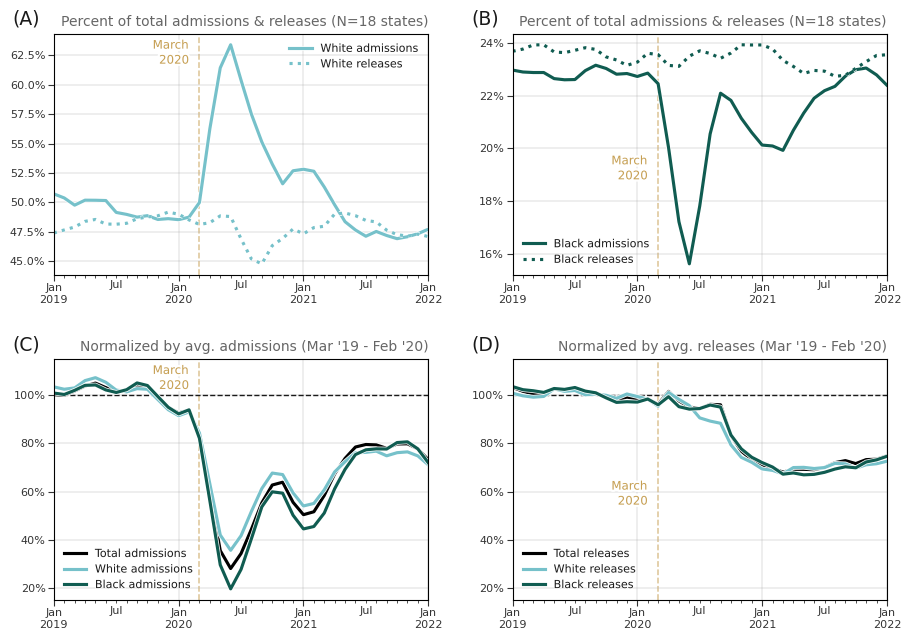

In [11]:
fig, ax = plt.subplots(2,2,figsize=(10.75,7.5),dpi=100)
plt.subplots_adjust(wspace=0.225, hspace=0.35)

pct_bla_ad = (ad_dfg['admissions_black']/ad_dfg['admissions_total'])
pct_whi_ad = (ad_dfg['admissions_white']/ad_dfg['admissions_total'])
pct_bla_re = (ad_dfg['releases_black']/ad_dfg['releases_total'])
pct_whi_re = (ad_dfg['releases_white']/ad_dfg['releases_total'])
(pct_bla_ad).rolling(window=3).mean().plot(ax=ax[(0,1)],label='Black admissions',
                                           color=colors[1], lw=lw, path_effects=pe_dat_l)
(pct_whi_ad).rolling(window=3).mean().plot(ax=ax[(0,0)],label='White admissions',
                                           color=colors[0], lw=lw, path_effects=pe_dat_l)
(pct_bla_re).rolling(window=3).mean().plot(ax=ax[(0,1)],label='Black releases',
                                           color=colors[1], lw=lw, path_effects=pe_dat_l, ls=':')
(pct_whi_re).rolling(window=3).mean().plot(ax=ax[(0,0)],label='White releases',
                                           color=colors[0], lw=lw, path_effects=pe_dat_l, ls=':')


(ad_dfg['admissions_total']/ad_dfg['admissions_total']['2019-03-01':'2020-02-01'].mean()).rolling(window=3).mean().plot(ax=ax[(1,0)],
                                                        label='Total admissions', color='.0', lw=lw, ls='-', path_effects=pe_dat_l)
(ad_dfg['admissions_white']/ad_dfg['admissions_white']['2019-03-01':'2020-02-01'].mean()).rolling(window=3).mean().plot(ax=ax[(1,0)],
                                                        label='White admissions', color=colors[0], lw=lw, path_effects=pe_dat_l)
(ad_dfg['admissions_black']/ad_dfg['admissions_black']['2019-03-01':'2020-02-01'].mean()).rolling(window=3).mean().plot(ax=ax[(1,0)],
                                                        label='Black admissions', color=colors[1], lw=lw, path_effects=pe_dat_l)
(ad_dfg['releases_total']/ad_dfg['releases_total']['2019-03-01':'2020-02-01'].mean()).rolling(window=3).mean().plot(ax=ax[(1,1)],
                                                        label='Total releases', color='.0', lw=lw, ls='-', path_effects=pe_dat_l)
(ad_dfg['releases_white']/ad_dfg['releases_white']['2019-03-01':'2020-02-01'].mean()).rolling(window=3).mean().plot(ax=ax[(1,1)],
                                                        label='White releases', color=colors[0], lw=lw, path_effects=pe_dat_l)
(ad_dfg['releases_black']/ad_dfg['releases_black']['2019-03-01':'2020-02-01'].mean()).rolling(window=3).mean().plot(ax=ax[(1,1)],
                                                        label='Black releases', color=colors[1], lw=lw, path_effects=pe_dat_l)


ax[(0,0)].set_title('Percent of total admissions & releases (N=%i states)'%int(ad_dfg['state'].unique()[0]),
                    x=1.0, ha='right', color='.4', fontsize=fs)
ax[(0,1)].set_title('Percent of total admissions & releases (N=%i states)'%int(ad_dfg['state'].unique()[0]),
                    x=1.0, ha='right', color='.4', fontsize=fs)
ax[(1,0)].set_title("Normalized by avg. admissions (Mar '19 - Feb '20)", x=1.0, ha='right', color='.4', fontsize=fs)
ax[(1,1)].set_title("Normalized by avg. releases (Mar '19 - Feb '20)", x=1.0, ha='right', color='.4', fontsize=fs)

letts = ['(A)','(B)','(C)','(D)']
for ai,a in enumerate(fig.axes):
    a.text(-0.11, 1.02, letts[ai], fontsize=fs*1.35, transform=a.transAxes,
           ha='left', va='bottom', color='.1')

    a.grid(color='.7', alpha=al*0.3, lw=lw/2)
    a.set_xlabel('')
    if ai == 0:
        a.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=1))
    if ai > 0:
        a.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
    if ai > 1:
        ylims = a.get_ylim()
        ydiff = ylims[1]-ylims[0]
        a.set_ylim(ylims[0], ylims[1])
        a.hlines(1.0,min(ad_dfg.index),max(ad_dfg.index),ls='--',color='.1',lw=1)
        a.set_ylim(0.15, 1.15)

    if ai != 0:
        l = a.legend(loc=3, fontsize=fs*0.8, framealpha=0)
    else:
        l = a.legend(loc=0, fontsize=fs*0.8, framealpha=0)
    for t in l.get_texts():
        t.set_color('.1')
        t.set_path_effects(pe_lab_l)

    ylims = a.get_ylim()
    ydiff = ylims[1]-ylims[0]
    a.set_ylim(ylims[0], ylims[1])
    a.tick_params(which='major', length=4, pad=2, labelsize=fs*0.8,
                  labelcolor=label_cols['tick'], color=label_cols['tick'])
    a.tick_params(which='minor', length=2, pad=2, labelsize=fs*0.8,
                  labelcolor=label_cols['tick'], color=label_cols['tick'])
    a.vlines(pd.to_datetime(['2020-03-15']).min(), ylims[0], ylims[1], 
             color=label_cols['accent'], zorder=0, ls='--', lw=lw*0.5, alpha=0.6)

    if ai in [0,2]:
        a.text(pd.to_datetime(['2020-02-01']).min(), ylims[1]-ydiff*0.02,"March\n2020",
               ha='right', va='top', fontsize=fs*0.85, #rotation=90,
               color=label_cols['accent'], path_effects=pe_dat_l)
    else:
        a.text(pd.to_datetime(['2020-02-01']).min(), ylims[1]-ydiff*0.5,"March\n2020",
               ha='right', va='top', fontsize=fs*0.85, #rotation=90,
               color=label_cols['accent'], path_effects=pe_dat_l)

    a.set_xlim(pd.to_datetime(['2019-01-01']).min(),pd.to_datetime(['2022-01-01']).min())

plt.savefig('../figs/pngs/all_admissions_releases.png',bbox_inches='tight',dpi=425)
plt.savefig('../figs/pdfs/all_admissions_releases.pdf',bbox_inches='tight')
plt.show()

_________________

# Some supplementary figures

In [12]:
all_state_names = {'ak': 'Alaska', 'al': 'Alabama', 'ar': 'Arkansas',
                   'as': 'American Samoa',  'az': 'Arizona',
                   'ca': 'California', 'co': 'Colorado',
                   'ct': 'Connecticut', 'dc': 'District of Columbia',
                   'de': 'Delaware', 'fl': 'Florida', 'ga': 'Georgia',
                   'gu': 'Guam', 'hi': 'Hawaii', 'ia': 'Iowa',
                   'id': 'Idaho', 'il': 'Illinois', 'in': 'Indiana',
                   'ks': 'Kansas', 'ky': 'Kentucky', 'la': 'Louisiana',
                   'ma': 'Massachusetts', 'md': 'Maryland', 'me': 'Maine',
                   'mi': 'Michigan', 'mn': 'Minnesota', 'mo': 'Missouri',
                   'mp': 'Northern Mariana Islands', 'ms': 'Mississippi',
                   'mt': 'Montana', 'nc': 'North Carolina',
                   'nd': 'North Dakota', 'ne': 'Nebraska',
                   'nh': 'New Hampshire', 'nj': 'New Jersey',
                   'nm': 'New Mexico', 'nv': 'Nevada', 'ny': 'New York',
                   'oh': 'Ohio', 'ok': 'Oklahoma', 'or': 'Oregon',
                   'pa': 'Pennsylvania', 'pr': 'Puerto Rico',
                   'ri': 'Rhode Island', 'sc': 'South Carolina',
                   'sd': 'South Dakota', 'tn': 'Tennessee', 'tx': 'Texas',
                   'ut': 'Utah', 'va': 'Virginia',
                   'vi': 'Virgin Islands', 'vt': 'Vermont',
                   'wa': 'Washington', 'wi': 'Wisconsin',
                   'wv': 'West Virginia', 'wy': 'Wyoming'}

all_state_ids = {'01': 'al', '02': 'ak', '04': 'az', '05': 'ar',
                 '06': 'ca', '08': 'co', '09': 'ct', '10': 'de',
                 '11': 'dc', '12': 'fl', '13': 'ga', '15': 'hi',
                 '16': 'id', '17': 'il', '18': 'in', '19': 'ia',
                 '20': 'ks', '21': 'ky', '22': 'la', '23': 'me',
                 '24': 'md', '25': 'ma', '26': 'mi', '27': 'mn',
                 '28': 'ms', '29': 'mo', '30': 'mt', '31': 'ne',
                 '32': 'nv', '33': 'nh', '34': 'nj', '35': 'nm',
                 '36': 'ny', '37': 'nc', '38': 'nd', '39': 'oh',
                 '40': 'ok', '41': 'or', '42': 'pa', '44': 'ri',
                 '45': 'sc', '46': 'sd', '47': 'tn', '48': 'tx',
                 '49': 'ut', '50': 'vt', '51': 'va', '53': 'wa',
                 '54': 'wv', '55': 'wi', '56': 'wy', "60": 'as',
                 "66": 'gu', "72": 'pr', '78': 'vi', '69': 'mp'}

all_ids_state = {j:i for i,j in all_state_ids.items()}
all_names_state = {j:i for i,j in all_state_names.items()}

state_posx = {'ak': (0, 0), 'me': (0, 10),#'gu': (7, 0), 'vi': (7, 9), 'pr': (7, 8), 'mp': (7, 1),
              'vt': (1, 9), 'nh': (1, 10),'wa': (2, 0), 'id': (2, 1), 'mt': (2, 2), 'nd': (2, 3), 'mn': (2, 4),
              'il': (2, 5), 'wi': (2, 6), 'mi': (2, 7), 'ny': (2, 8), 'ri': (2, 9), 'ma': (2, 10),'or': (3, 0),
              'nv': (3, 1), 'wy': (3, 2), 'sd': (3, 3), 'ia': (3, 4), 'in': (3, 5), 'oh': (3, 6), 'pa': (3, 7),
              'nj': (3, 8), 'ct': (3, 9), 'ca': (4, 0), 'ut': (4, 1), 'co': (4, 2), 'ne': (4, 3), 'mo': (4, 4),
              'ky': (4, 5), 'wv': (4, 6), 'va': (4, 7), 'md': (4, 8), 'de': (4, 9), 'az': (5, 1), 'nm': (5, 2), 
              'ks': (5, 3), 'ar': (5, 4), 'tn': (5, 5), 'nc': (5, 6), 'sc': (5, 7), 'dc': (5, 8), 'ok': (6, 3),
              'la': (6, 4), 'ms': (6, 5), 'al': (6, 6), 'ga': (6, 7), 'hi': (6, 0), 'tx': (7, 3), 'fl': (7, 7)}

month_dict = {'01':'January','02':'February','03':'March','04':'April','05':'May','06':'June',
              '07':'July','08':'August','09':'September','10':'October','11':'November','12':'December'}
month_abbr = {'January':'Jan','February':'Feb','March':'Mar','April':'Apr','May':"May",'June':'Jun',
              'July':"Jul",'August':"Aug",'September':'Sep','October':"Oct",'November':'Nov','December':'Dec'}

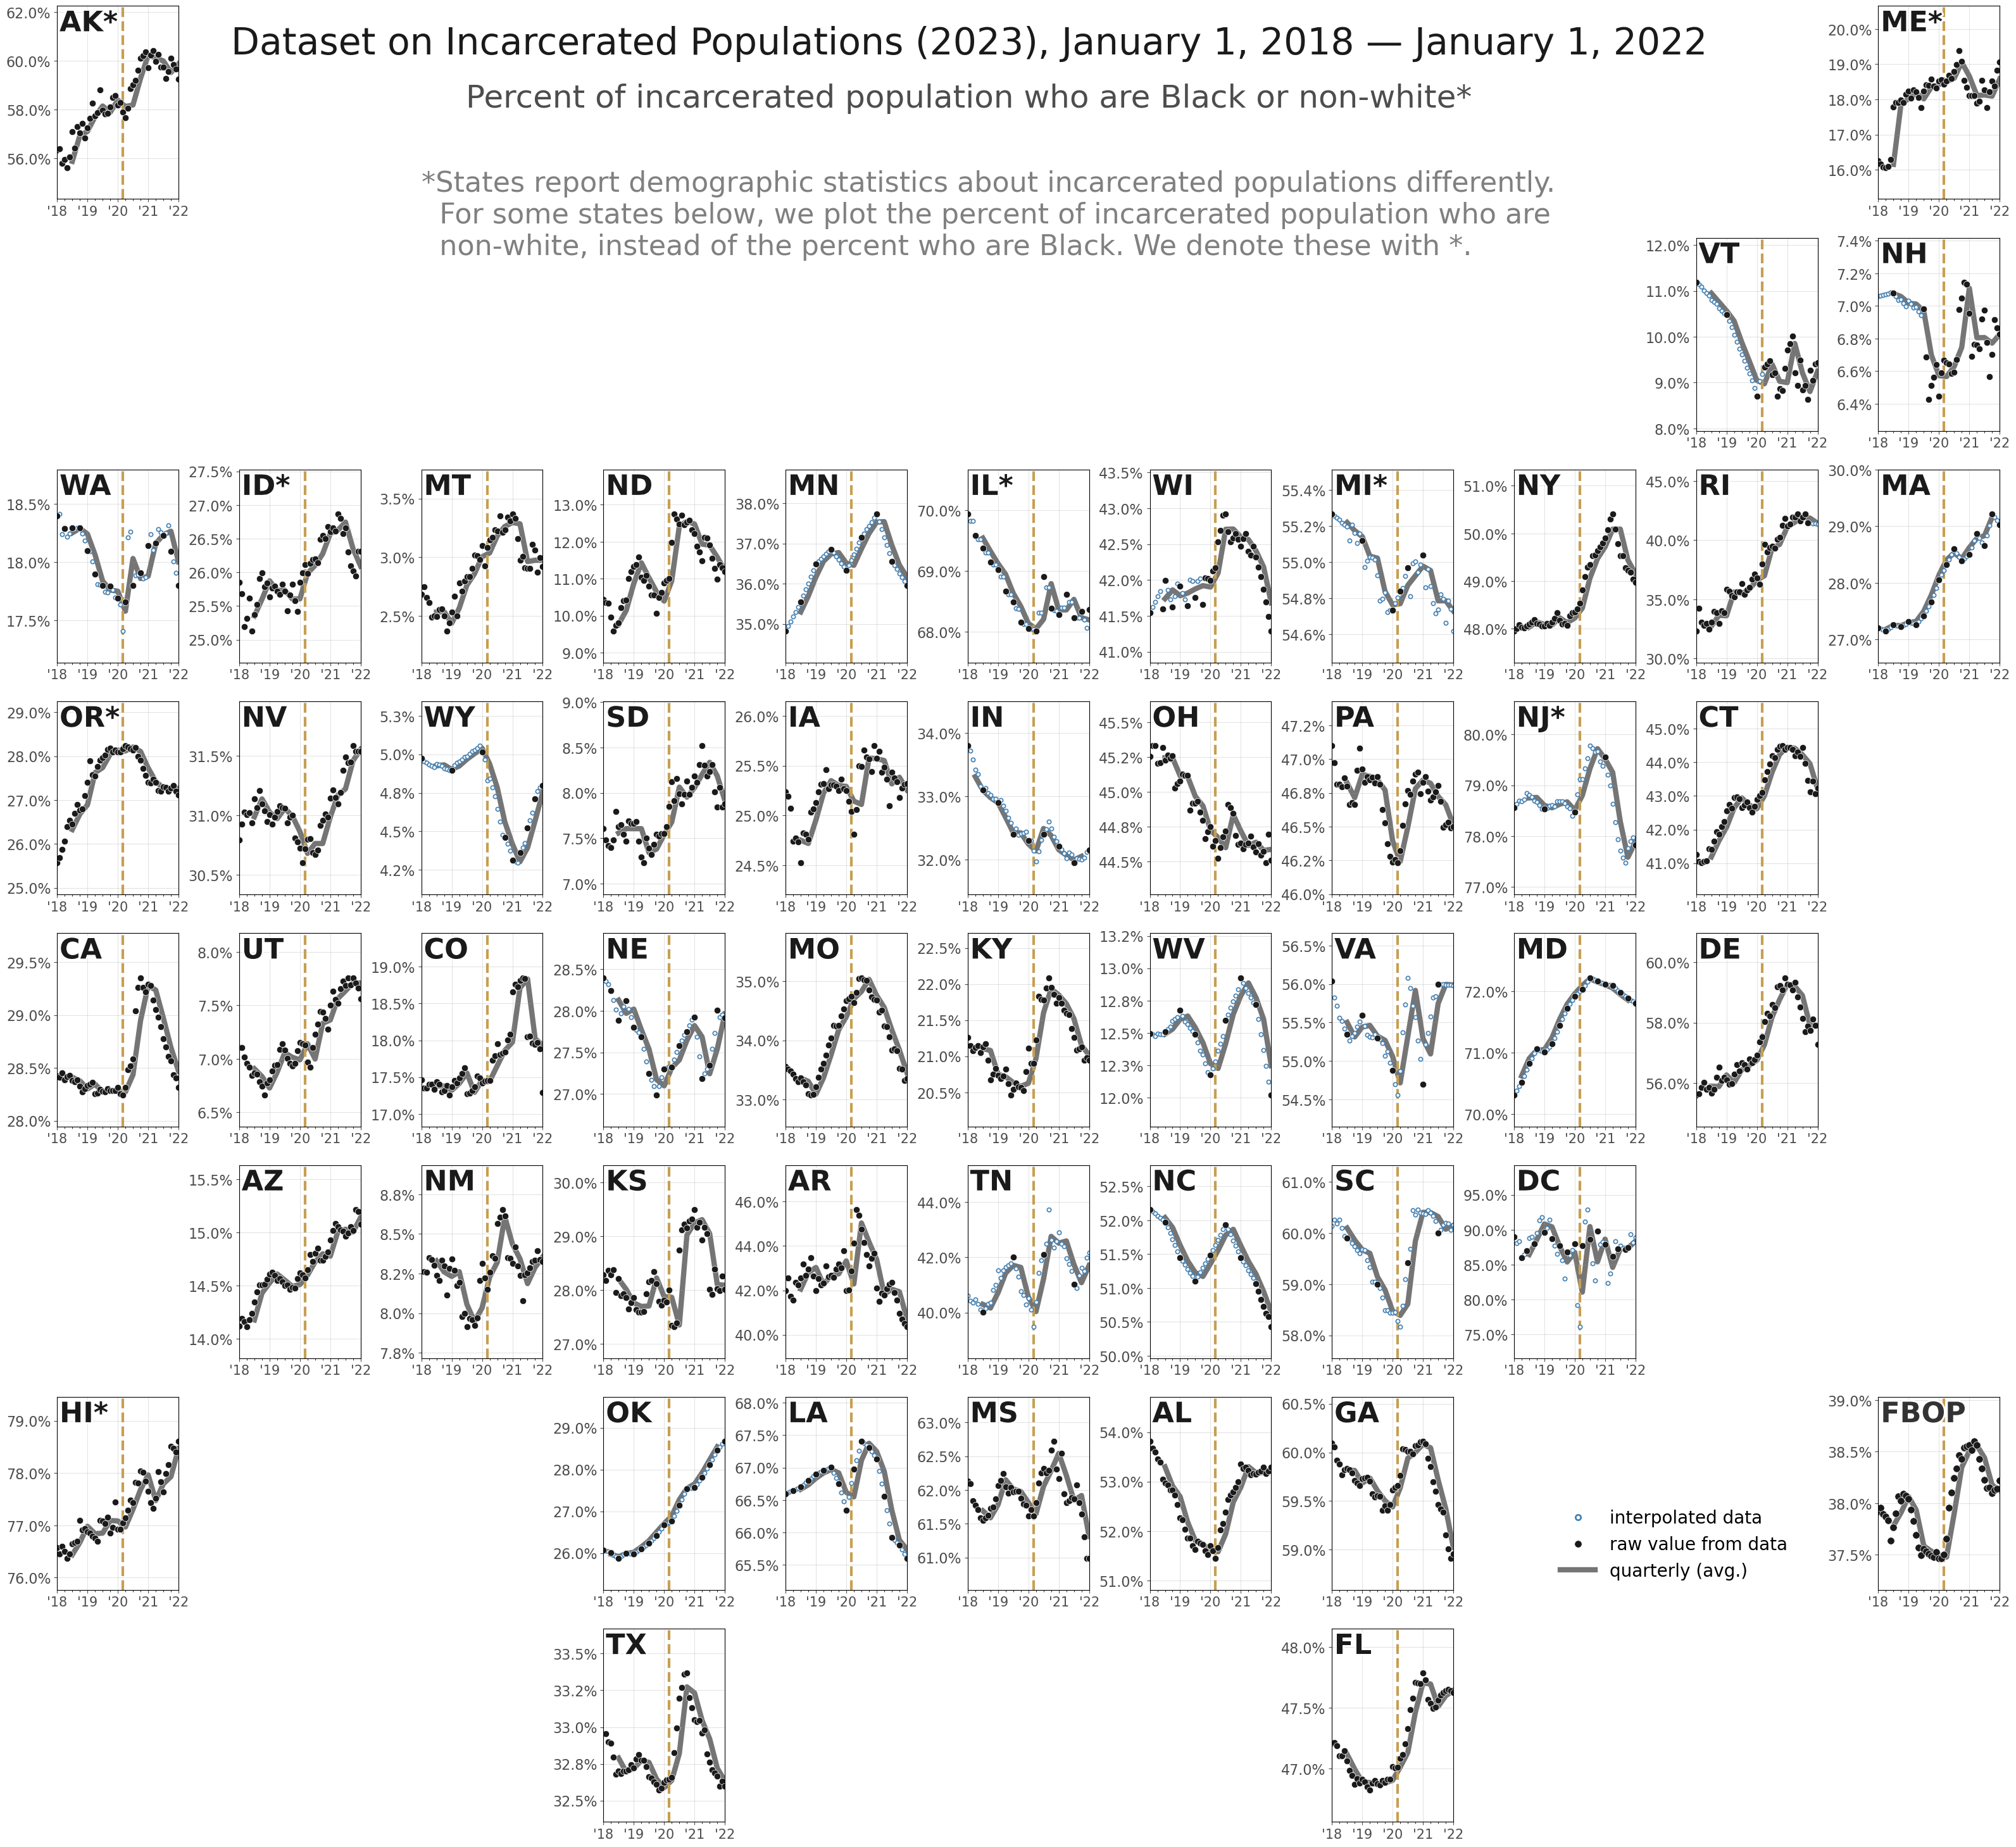

In [25]:
wid = 4
w = 3.6; h = 4.75
ncols = 11; nrows = 8
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=100)#, sharex=True)
plt.subplots_adjust(wspace=0.5,hspace=0.2)
stdate = '2017-12-01'
endate = '2022-02-01'
ms = 15

for st, po in list(state_posx.items()):#[11:15]:#
    rcol = 'incarcerated_black'
    tcol = 'incarcerated_total'

    stlab = all_state_names[st]
    if stlab in ['Michigan','Alaska','Illinois','New Jersey','Hawaii','Oregon','Maine','Idaho']:
        rcol = 'incarcerated_nonwhite'
    
    if stlab in ['Northern Mariana Islands','Virgin Islands','Guam',
                 'Puerto Rico']:
        ax[po].set_axis_off()
        continue

    else:
        df_i = df.loc[(df['state']==stlab)&\
                      (df['date']>stdate)&\
                      (df['date']<endate)].copy()
        df_i['date'] = pd.to_datetime(df_i['date'])
        df_i = df_i.set_index('date')

        cccd = '#205078'
        cccl = '#5B98C5'
        cold = 'incarcerated_total'
        titleab = all_names_state[stlab].upper()
        if 'black' not in rcol:
            cccd = '#BF3550'
            cccl = '#B86373'
            titleab = all_names_state[stlab].upper()+r"*"

        cccd = '.1'
        cccl = '.4'
            
        if st in ['Virginia','Maryland','Colorado']:
            if st == 'Colorado':
                if 'black' not in rcol:
                    df_i[rcol]['2021-01-01':] = np.nan
            if st == 'Maryland':
                if 'black' not in rcol:
                    df_i[rcol]['2021-01-01':] = np.nan
            if st == 'Virginia':
                df_i[rcol]['2021-02-01':] = np.nan

        all_vals = df_i[rcol]/df_i[tcol]
        df_i_raw = df_i.copy()
        df_i_raw.loc[df_i_raw['data_or_inferred']!='raw data',rcol] = np.nan
        df_i_nonraw = df_i.copy()
        df_i_nonraw.loc[df_i_nonraw['data_or_inferred']=='raw data',rcol] = np.nan

        all_vals.plot(ax=ax[po], lw=0, color='w')

        if df_i['data_or_inferred'].nunique()>1:
            (df_i_nonraw[rcol]/df_i_nonraw[tcol]).plot(ax=ax[po],marker='.',lw=0,
                                                       markersize=ms*0.6,markeredgewidth=1.25,
                                                       markeredgecolor='steelblue', color='w')
        else:
            all_vals[:1].plot(ax=ax[po],marker='.',lw=0,
                              markersize=ms*0.6,markeredgewidth=1.25,
                              markeredgecolor='steelblue', color='w')

        (df_i_raw[rcol]/df_i_raw[tcol]).plot(ax=ax[po],marker='.',markersize=ms,
                                             markeredgewidth=0.5,markeredgecolor='w',
                                             lw=0, label='raw value from data', color='.1')

        df_iq = df_i.copy()
        qvals = (df_iq[rcol].resample('Q').mean()/df_iq[tcol].resample('Q').mean())
        qvals_i = qvals[1:-1].copy()
        if stlab not in ['Oklahoma','Maryland','Massachusetts','Indiana']:
            qvals_i.index = qvals_i.index + pd.DateOffset(months=1)
        qvals_i.plot(ax=ax[po],lw=6,label='quarterly (avg.)', color='.4', alpha=0.9, zorder=0)

        ax[po].set_xlabel('')

        text = ax[po].text(0.02,0.98,titleab,
                           fontsize=32,va='top',ha='left',
                           color=cccd,fontweight='bold',transform=ax[po].transAxes,
                           path_effects=[path_effects.Stroke(linewidth=4, foreground='w'),
                               path_effects.Normal()])

        ylimi = ax[po].get_ylim()
        ydifi = ylimi[1]-ylimi[0]
        ax[po].vlines(pd.to_datetime(['2020-03-01']).min(),
                      ylimi[0]-(0.2*ydifi), ylimi[1]+(0.3*ydifi),
                      color='#C69F52',ls='--',lw=3)

        ax[po].yaxis.set_major_formatter(mtick.PercentFormatter(1.0,decimals=1))
        ax[po].set_xticks(pd.to_datetime(list(df_i.index[::12].astype(str))), minor=False)
        ax[po].set_xticklabels(["'"+i[2:4] for i in list(df_i.index[::12].astype(str))])

        ax[po].tick_params(labelcolor='.3',color='.3',labelsize=16)
        ax[po].tick_params(axis='x', labelcolor='.3',color='.3',labelsize=15)
        ax[po].grid(linewidth=0.5,color='.6',alpha=0.4)
        ax[po].set_ylim(ylimi[0]-(0.2*ydifi), ylimi[1]+(0.3*ydifi))

        
po = (6, 10)

df_i = df.loc[(df['state']=='Federal')&\
              (df['date']>stdate)&\
              (df['date']<endate)].copy()
df_i['date'] = pd.to_datetime(df_i['date'])
df_i = df_i.set_index('date')

cccd = '#205078'
cccl = '#5B98C5'
cold = 'incarcerated_total'
titleab = all_names_state[stlab].upper()
if 'black' not in rcol:
    cccd = '#BF3550'
    cccl = '#B86373'
    titleab = all_names_state[stlab].upper()+r"*"

cccd = '.1'
cccl = '.4'

if st in ['Virginia','Maryland','Colorado']:
    if st == 'Colorado':
        if 'black' not in rcol:
            df_i[rcol]['2021-01-01':] = np.nan
    if st == 'Maryland':
        if 'black' not in rcol:
            df_i[rcol]['2021-01-01':] = np.nan
    if st == 'Virginia':
        df_i[rcol]['2021-02-01':] = np.nan

all_vals = df_i[rcol]/df_i[tcol]
df_i_raw = df_i.copy()
df_i_raw.loc[df_i_raw['data_or_inferred']!='raw data',rcol] = np.nan
df_i_nonraw = df_i.copy()
df_i_nonraw.loc[df_i_nonraw['data_or_inferred']=='raw data',rcol] = np.nan

all_vals.plot(ax=ax[po], lw=0, color='w', label='_nolegend_')

all_vals[:1].plot(ax=ax[po],marker='.',lw=0,label='interpolated data',
                      markersize=ms*0.8,markeredgewidth=2,
                      markeredgecolor='steelblue', color='w')

(df_i_raw[rcol]/df_i_raw[tcol]).plot(ax=ax[po],marker='.',markersize=ms*1.1,
                                     markeredgewidth=0.5,markeredgecolor='w',
                                     lw=0, label='raw value from data', color='.1')

df_iq = df_i.copy()
qvals = (df_iq[rcol].resample('Q').mean()/df_iq[tcol].resample('Q').mean())
qvals_i = qvals[1:-1].copy()
qvals_i.index = qvals_i.index + pd.DateOffset(months=1)
qvals_i.plot(ax=ax[po],lw=6,label='quarterly (avg.)', color='.4', alpha=0.9, zorder=0)

ax[po].set_xlabel('')

text = ax[po].text(0.02,0.98,'FBOP',
                   fontsize=32,va='top',ha='left',
                   color=cccd,fontweight='bold',transform=ax[po].transAxes,
                   path_effects=[path_effects.Stroke(linewidth=4, foreground='w'),
                       path_effects.Normal()])

ylimi = ax[po].get_ylim()
ydifi = ylimi[1]-ylimi[0]
ax[po].vlines(pd.to_datetime(['2020-03-01']).min(),
              ylimi[0]-(0.2*ydifi), ylimi[1]+(0.3*ydifi),
              color='#C69F52',ls='--',lw=3)

ax[po].yaxis.set_major_formatter(mtick.PercentFormatter(1.0,decimals=1))
ax[po].set_xticks(pd.to_datetime(list(df_i.index[::12].astype(str))), minor=False)
ax[po].set_xticklabels(["'"+i[2:4] for i in list(df_i.index[::12].astype(str))])

ax[po].tick_params(labelcolor='.3',color='.3',labelsize=16)
ax[po].tick_params(axis='x', labelcolor='.3',color='.3',labelsize=15)
ax[po].grid(linewidth=0.5,color='.6',alpha=0.4)
ax[po].set_ylim(ylimi[0]-(0.2*ydifi), ylimi[1]+(0.3*ydifi))

text = ax[po].text(0.02,0.98,'FBOP',
                   fontsize=32,va='top',ha='left',
                   color='.2',fontweight='bold',transform=ax[po].transAxes,
                   path_effects=[path_effects.Stroke(linewidth=4, foreground='w'),
                       path_effects.Normal()])
ax[po].legend(bbox_to_anchor=[-2.75, 0.5], loc=2, fontsize=fs*2, framealpha=0)


for tup in tups:
    if tup not in state_posx.values() and tup != po:
        ax[tup].set_axis_off()


ax[(0,5)].text(0.01,0.9,"Dataset on Incarcerated Populations (2023), January 1, 2018 — January 1, 2022",
               color='.1', fontsize=42
               , va='top', ha='center', transform=ax[(0,5)].transAxes)
ax[(0,5)].text(0.01,0.6,"Percent of incarcerated population who are Black or non-white*",
               color='.3', fontsize=36, va='top', ha='center', transform=ax[(0,5)].transAxes)
ax[(0,2)].text(0.0,0.15,"*States report demographic statistics about incarcerated populations differently.\n"+
               "  For some states below, we plot the percent of incarcerated population who are\n"+\
               "  non-white, instead of the percent who are Black. We denote these with *.",
               color='.5', fontsize=32, va='top', ha='left', transform=ax[(0,2)].transAxes)

plt.savefig('../figs/pngs/incarceration_percent_black_nonwhite_2018_2022.png', dpi=300, bbox_inches='tight')
plt.savefig('../figs/pdfs/incarceration_percent_black_nonwhite_2018_2022.pdf', bbox_inches='tight')

plt.show()

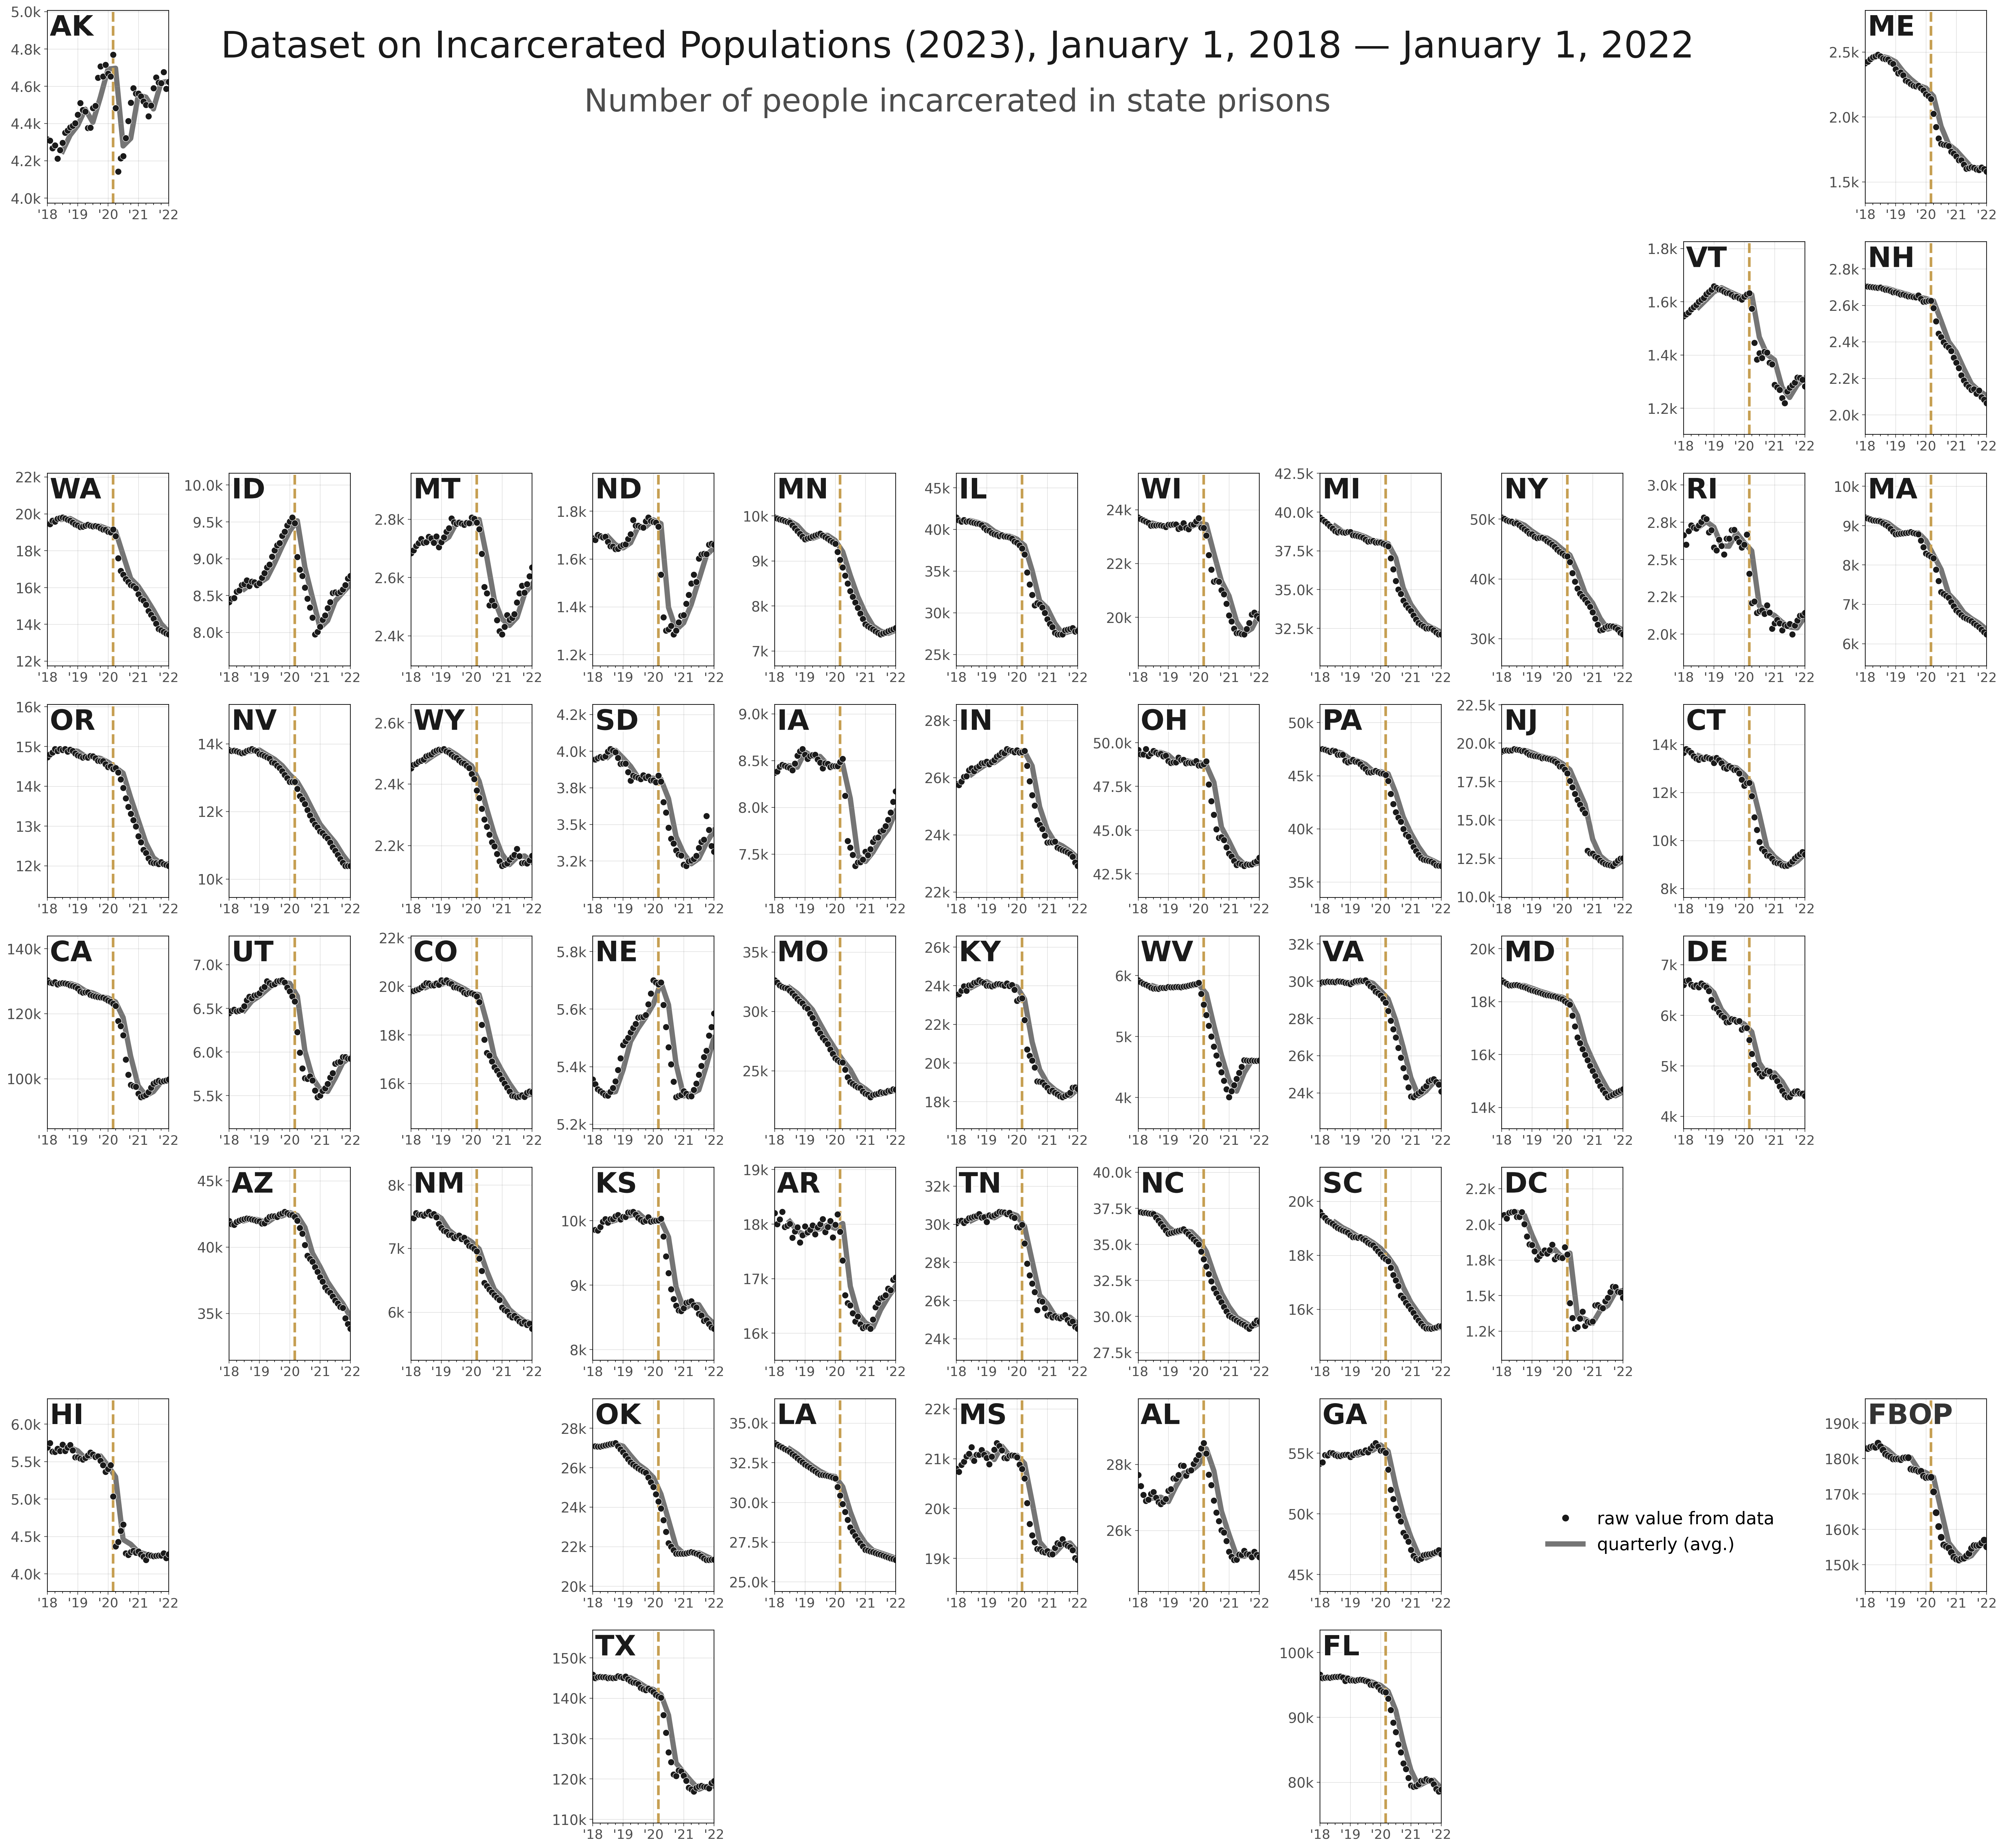

In [26]:
wid = 4
w = 3.6; h = 4.75
ncols = 11; nrows = 8
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=200)#, sharex=True)
plt.subplots_adjust(wspace=0.5,hspace=0.2)
stdate = '2017-12-01'
endate = '2022-02-01'
ms = 15

for st, po in list(state_posx.items()):#[11:15]:#
    rcol = 'incarcerated_black'
    tcol = 'incarcerated_total'

    stlab = all_state_names[st]
    if stlab in ['Michigan','Alaska','Illinois','New Jersey','Hawaii']:
        rcol = 'incarcerated_nonwhite'
    
    if stlab in ['Northern Mariana Islands','Virgin Islands','Guam',
                 'Puerto Rico']:
        ax[po].set_axis_off()
        continue

    else:
        df_i = df.loc[(df['state']==stlab)&\
                      (df['date']>stdate)&\
                      (df['date']<endate)].copy()
        df_i['date'] = pd.to_datetime(df_i['date'])
        df_i = df_i.set_index('date')

        cccd = '#205078'
        cccl = '#5B98C5'
        cold = 'incarcerated_total'
        titleab = all_names_state[stlab].upper()
        # if 'black' not in rcol:
        #     cccd = '#BF3550'
        #     cccl = '#B86373'
        #     titleab = all_names_state[stlab].upper()+r"*"

        cccd = '.1'
        cccl = '.4'
            
        if st in ['Virginia','Maryland','Colorado']:
            if st == 'Colorado':
                if 'black' not in rcol:
                    df_i[rcol]['2021-01-01':] = np.nan
            if st == 'Maryland':
                if 'black' not in rcol:
                    df_i[rcol]['2021-01-01':] = np.nan
            if st == 'Virginia':
                df_i[rcol]['2021-02-01':] = np.nan

        all_vals = df_i[tcol]
        df_i_raw = df_i.copy()
        df_i_raw.loc[df_i_raw['data_or_inferred']!='raw data',rcol] = np.nan
        df_i_nonraw = df_i.copy()
        df_i_nonraw.loc[df_i_nonraw['data_or_inferred']=='raw data',rcol] = np.nan

        all_vals.plot(ax=ax[po], lw=0, color='w')

        if df_i['data_or_inferred'].nunique()>1:
            df_i_nonraw[tcol].plot(ax=ax[po],marker='.',lw=0,
                                                       markersize=ms*0.7,markeredgewidth=1.5,
                                                       markeredgecolor='steelblue', color='w')
        else:
            all_vals[:1].plot(ax=ax[po],marker='.',lw=0,
                              markersize=ms*0.7,markeredgewidth=1.5,
                              markeredgecolor='steelblue', color='w')

        df_i_raw[tcol].plot(ax=ax[po],marker='.',markersize=ms,
                                             markeredgewidth=0.5,markeredgecolor='w',
                                             lw=0, label='raw value from data', color='.1')

        df_iq = df_i.copy()
        qvals = df_iq[tcol].resample('Q').mean()
        qvals_i = qvals[1:-1].copy()
        qvals_i.index = qvals_i.index + pd.DateOffset(months=1)
        qvals_i.plot(ax=ax[po],lw=6,label='quarterly (avg.)', color='.4', alpha=0.9, zorder=0)

        ax[po].set_xlabel('')

        text = ax[po].text(0.02,0.98,titleab,
                           fontsize=32,va='top',ha='left',
                           color=cccd,fontweight='bold',transform=ax[po].transAxes,
                           path_effects=[path_effects.Stroke(linewidth=4, foreground='w'),
                               path_effects.Normal()])

        ylimi = ax[po].get_ylim()
        ydifi = ylimi[1]-ylimi[0]
        ax[po].vlines(pd.to_datetime(['2020-03-01']).min(),
                      ylimi[0]-(0.2*ydifi), ylimi[1]+(0.3*ydifi),
                      color='#C69F52',ls='--',lw=3)

        ax[po].set_xticks(pd.to_datetime(list(df_i.index[::12].astype(str))), minor=False)
        ax[po].set_xticklabels(["'"+i[2:4] for i in list(df_i.index[::12].astype(str))])

        ax[po].tick_params(labelcolor='.3',color='.3',labelsize=16)
        ax[po].tick_params(axis='x', labelcolor='.3',color='.3',labelsize=15)
        ax[po].grid(linewidth=0.5,color='.6',alpha=0.4)
        ylabels = ['{:,.1f}'.format(x) + 'k' for x in ax[po].get_yticks()/1000]
        decs = np.unique([i.replace('k','').split('.')[-1] for i in ylabels])
        if len(decs) == 1 and decs[0]=='0':
            ylabels = [i.replace('.0','') for i in ylabels]
        ax[po].set_yticks(ax[po].get_yticks())
        ax[po].set_yticklabels(ylabels)
        
        ax[po].set_ylim(ylimi[0]-(0.2*ydifi), ylimi[1]+(0.3*ydifi))

        
po = (6, 10)

df_i = df.loc[(df['state']=='Federal')&\
              (df['date']>stdate)&\
              (df['date']<endate)].copy()
df_i['date'] = pd.to_datetime(df_i['date'])
df_i = df_i.set_index('date')

cccd = '#205078'
cccl = '#5B98C5'
cold = 'incarcerated_total'
titleab = all_names_state[stlab].upper()
# if 'black' not in rcol:
#     cccd = '#BF3550'
#     cccl = '#B86373'
#     titleab = all_names_state[stlab].upper()+r"*"

cccd = '.1'
cccl = '.4'

all_vals = df_i[tcol]
df_i_raw = df_i.copy()
df_i_raw.loc[df_i_raw['data_or_inferred']!='raw data',rcol] = np.nan
df_i_nonraw = df_i.copy()
df_i_nonraw.loc[df_i_nonraw['data_or_inferred']=='raw data',rcol] = np.nan

all_vals.plot(ax=ax[po], lw=0, color='w', label='_nolegend_')

# all_vals[:1].plot(ax=ax[po],marker='.',lw=0,label='interpolated data',
#                       markersize=ms*0.8,markeredgewidth=2,
#                       markeredgecolor='steelblue', color='w')

df_i_raw[tcol].plot(ax=ax[po],marker='.',markersize=ms*1.1,
                                     markeredgewidth=0.5,markeredgecolor='w',
                                     lw=0, label='raw value from data', color='.1')

df_iq = df_i.copy()
qvals = df_iq[tcol].resample('Q').mean()
qvals_i = qvals[1:-1].copy()
qvals_i.index = qvals_i.index + pd.DateOffset(months=1)
qvals_i.plot(ax=ax[po],lw=6,label='quarterly (avg.)', color='.4', alpha=0.9, zorder=0)

ax[po].set_xlabel('')

text = ax[po].text(0.02,0.98,'FBOP',
                   fontsize=32,va='top',ha='left',
                   color=cccd,fontweight='bold',transform=ax[po].transAxes,
                   path_effects=[path_effects.Stroke(linewidth=4, foreground='w'),
                       path_effects.Normal()])

ylimi = ax[po].get_ylim()
ydifi = ylimi[1]-ylimi[0]
ax[po].vlines(pd.to_datetime(['2020-03-01']).min(),
              ylimi[0]-(0.2*ydifi), ylimi[1]+(0.3*ydifi),
              color='#C69F52',ls='--',lw=3)

ax[po].set_xticks(pd.to_datetime(list(df_i.index[::12].astype(str))), minor=False)
ax[po].set_xticklabels(["'"+i[2:4] for i in list(df_i.index[::12].astype(str))])

ax[po].tick_params(labelcolor='.3',color='.3',labelsize=16)
ax[po].tick_params(axis='x', labelcolor='.3',color='.3',labelsize=15)
ax[po].grid(linewidth=0.5,color='.6',alpha=0.4)
ylabels = ['{:,.1f}'.format(x) + 'k' for x in ax[po].get_yticks()/1000]
decs = np.unique([i.replace('k','').split('.')[-1] for i in ylabels])
if len(decs) == 1 and decs[0]=='0':
    ylabels = [i.replace('.0','') for i in ylabels]
ax[po].set_yticks(ax[po].get_yticks())
ax[po].set_yticklabels(ylabels)
ax[po].set_ylim(ylimi[0]-(0.2*ydifi), ylimi[1]+(0.3*ydifi))

text = ax[po].text(0.02,0.98,'FBOP',
                   fontsize=32,va='top',ha='left',
                   color='.2',fontweight='bold',transform=ax[po].transAxes,
                   path_effects=[path_effects.Stroke(linewidth=4, foreground='w'),
                       path_effects.Normal()])
ax[po].legend(bbox_to_anchor=[-2.75, 0.5], loc=2, fontsize=fs*2, framealpha=0)


for tup in tups:
    if tup not in state_posx.values() and tup != po:
        ax[tup].set_axis_off()


ax[(0,5)].text(0.01,0.9,"Dataset on Incarcerated Populations (2023), January 1, 2018 — January 1, 2022",
               color='.1', fontsize=42
               , va='top', ha='center', transform=ax[(0,5)].transAxes)
ax[(0,5)].text(0.01,0.6,"Number of people incarcerated in state prisons",
               color='.3', fontsize=36, va='top', ha='center', transform=ax[(0,5)].transAxes)

plt.savefig('../figs/pngs/incarcerated_population_2018_2022.png', dpi=300, bbox_inches='tight')
plt.savefig('../figs/pdfs/incarcerated_population_2018_2022.pdf', bbox_inches='tight')

plt.show()